In [1]:
# ===========================================
# Task 4: Proxy Target Variable Creation (RFM + KMeans)
# ===========================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Load the transaction data
data = pd.read_csv('../data/raw/data.csv')

# Convert TransactionStartTime to datetime
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])

data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


## RFM + KMeans Clustering

| ✅ **RFM**         | → A way to describe customer behavior using 3 numbers:        |
| ----------------- | ------------------------------------------------------------- |
| **R = Recency**   | How recently did the customer transact? (Fewer days = better) |
| **F = Frequency** | How often did they transact? (More = better)                  |
| **M = Monetary**  | How much money did they spend? (More = better)                |


In [3]:
# Compute RFM Features
# Reference date (latest date in data)
reference_date = data['TransactionStartTime'].max()

# ✅ Compute RFM using consistent named aggregation
rfm = data.groupby('CustomerId').agg(
    Recency=('TransactionStartTime', lambda x: (reference_date - x.max()).days),
    Frequency=('TransactionId', 'count'),
    Monetary=('Amount', 'sum')
).reset_index()

rfm.head()


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,83,1,-10000.0
1,CustomerId_10,83,1,-10000.0
2,CustomerId_1001,89,5,20000.0
3,CustomerId_1002,25,11,4225.0
4,CustomerId_1003,11,6,20000.0


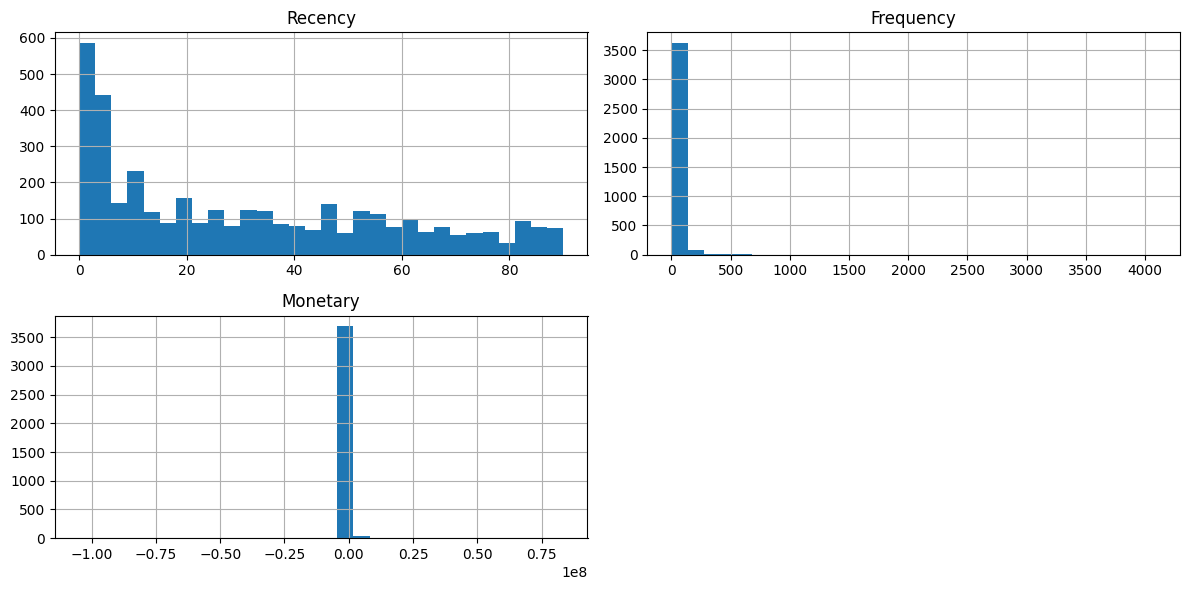

In [4]:
#  Explore RFM Distributions
rfm.describe()

# Plot histograms
rfm[['Recency', 'Frequency', 'Monetary']].hist(figsize=(12, 6), bins=30)
plt.tight_layout()
plt.show()


In [5]:
# Scale RFM Data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


🔥 Clustering (KMeans)
We don’t tell the model who is good/bad.

We ask the algorithm to group customers into clusters based on their RFM behavior.

The result might be 3 groups:

Cluster 0: High value

Cluster 1: Medium value

Cluster 2: Low value

✔️ This Cluster label becomes our proxy target variable.

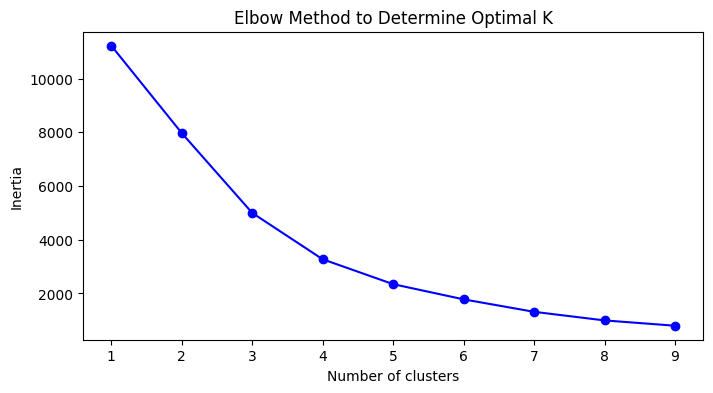

In [6]:
# Find Optimal Clusters (Elbow Method)
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.show()

# NOTE:  Look for the "elbow" point where the curve starts to flatten.

In [7]:
# Apply KMeans Clustering
# Assuming 3 clusters based on elbow (you can change to 4 or 5 based on your elbow plot)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,CustomerId,Recency,Frequency,Monetary,Cluster
0,CustomerId_1,83,1,-10000.0,0
1,CustomerId_10,83,1,-10000.0,0
2,CustomerId_1001,89,5,20000.0,0
3,CustomerId_1002,25,11,4225.0,1
4,CustomerId_1003,11,6,20000.0,1


In [8]:
# Interpret Clusters
# Summary statistics by cluster
summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerId': 'count'
}).rename(columns={'CustomerId': 'Num_Customers'})

summary
# ✔️ ➕ Lower Recency = better customer
# ➕ Higher Frequency and Monetary = better customer

,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,60.877279,7.720196,8.172068e+04,1426
1,11.726566,34.800000,2.725741e+05,2315
2,28.000000,4091.000000,-1.049000e+08,1


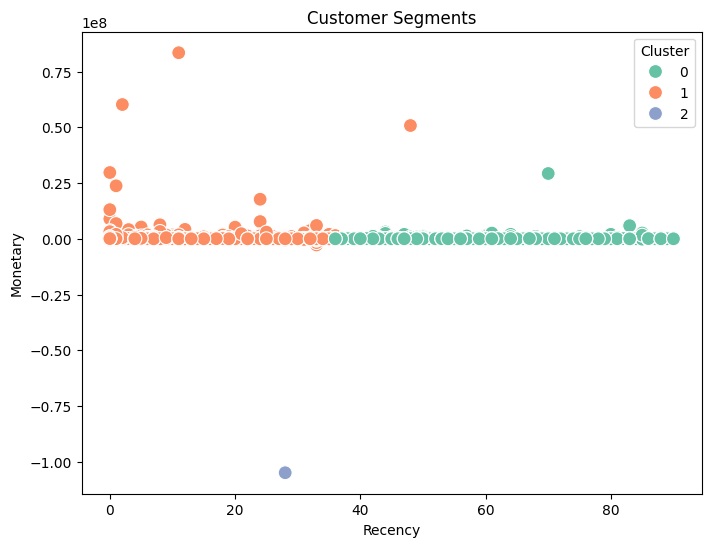

In [9]:
#  Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title('Customer Segments')
plt.show()


In [10]:
# Save Proxy Target
rfm[['CustomerId', 'Cluster']].to_csv('../data/processed/proxy_target.csv', index=False)

print("Proxy target saved to '../data/processed/proxy_target.csv'")


Proxy target saved to '../data/processed/proxy_target.csv'


In [11]:
#  Merge Back to Main Data
# Merge cluster labels back to the main data
data_with_cluster = pd.merge(data, rfm[['CustomerId', 'Cluster']], on='CustomerId', how='left')

data_with_cluster.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Cluster
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,1
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,1
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0,1
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0,1


Save to `data_with_cluster.csv`

In [12]:
data_with_cluster.to_csv('../data/processed/data_with_cluster.csv', index=False)